In [138]:
import os, time
import numpy as np
import fitsio
import matplotlib.pyplot as plt
from astropy.table import Table

### Check the masking

In [130]:
MASKBITS = dict(
    NPRIMARY   = 0x1,   # not PRIMARY
    BRIGHT     = 0x2,
    SATUR_G    = 0x4,
    SATUR_R    = 0x8,
    SATUR_Z    = 0x10,
    ALLMASK_G  = 0x20,
    ALLMASK_R  = 0x40,
    ALLMASK_Z  = 0x80,
    WISEM1     = 0x100, # WISE masked
    WISEM2     = 0x200,
    BAILOUT    = 0x400, # bailed out of processing
    MEDIUM     = 0x800, # medium-bright star
    GALAXY     = 0x1000, # LSLGA large galaxy
    CLUSTER    = 0x2000, # Cluster catalog source
)

# Bits in the "brightblob" bitmask
IN_BLOB = dict(
    BRIGHT = 0x1,
    MEDIUM = 0x2,
    CLUSTER = 0x4,
    GALAXY = 0x8,
)

In [146]:
gaia = Table.read('check-gaia-decam.fits')
gaia

BRICKNAME,BRICK_PRIMARY,BRIGHTBLOB,MASKBITS,TYPE,RA,DEC,BX,BY,REF_CAT,REF_ID,GAIA_PHOT_G_MEAN_MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z
bytes8,bool,int16,int16,bytes4,float64,float64,float32,float32,bytes2,int64,float32,float32,float32,float32,float32,float32,float32
1350p335,True,0,1,PSF,134.92843243478697,33.37501767093805,2620.7034,82.46497,,0,0.0,0.2897492,0.4860415,0.63876486,1476.666,474.39328,94.09064
1350p335,True,0,0,PSF,134.92885028772062,33.375601887514954,2615.9033,90.489136,,0,0.0,0.21821792,0.52454865,0.6644881,1488.9829,474.3993,94.199844
1350p335,True,0,0,PSF,135.1316878222775,33.375756713164314,288.45737,93.292946,G2,713287247735953280,16.93665,98.71353,188.55865,248.89647,142.83481,56.931503,34.93273
1350p335,True,2,2064,PSF,135.07846141248947,33.377421812643824,899.2179,115.55612,G2,713288141089101696,15.411125,528.58527,719.9368,753.5154,31.101421,16.9854,8.076427
1350p335,True,2,2048,PSF,135.07897199625378,33.3755246475573,893.33954,89.4925,G2,713288141089102080,18.129564,28.35335,64.81519,94.44299,385.91187,127.05324,55.148693
1350p335,True,0,0,PSF,134.87904349417235,33.37581612280609,3187.4058,93.959915,G2,713290374472102912,17.24975,35.571926,128.53609,323.0675,332.55164,80.33479,28.643694
1350p335,True,0,0,PSF,135.0121329930715,33.3755358095466,1660.2806,89.31043,,0,0.0,0.1415862,0.25523955,0.5262368,1512.96,474.5875,66.08998
1350p335,True,0,0,PSF,134.95280071585944,33.3752986402654,2341.0872,86.166214,G2,713290198376942336,19.616259,8.670692,15.927548,22.119194,561.4854,130.46448,46.514046
1350p335,True,0,0,REX,134.88782341398388,33.37582776462404,3086.661,94.007126,,0,0.0,0.06783101,0.31473637,1.9846932,1303.8052,403.57907,76.660934


#### All DUPs should be in an LSLGA blob.

In [132]:
idup = gaia['TYPE'] == 'DUP'
assert(np.all(gaia[idup]['MASKBITS'] & MASKBITS['GALAXY'] != 0))
assert(np.all(gaia[idup]['FLUX_G'] == 0))
for band in ('G', 'R', 'Z'):
    assert(np.all(gaia[idup]['FLUX_{}'.format(band)] == 0))
    assert(np.all(gaia[idup]['FLUX_IVAR_{}'.format(band)] == 0))
gaia[idup]

BRICKNAME,BRICK_PRIMARY,BRIGHTBLOB,MASKBITS,TYPE,RA,DEC,REF_CAT,REF_ID,GAIA_PHOT_G_MEAN_MAG,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z
bytes8,bool,int16,int16,bytes4,float64,float64,bytes2,int64,float32,float32,float32,float32,float32,float32,float32
,True,0,4096,DUP,135.09500547158228,33.005760519695784,G2,713261542354836096,18.46803,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.45765263482355,32.873589504953294,G2,712500306647728000,19.099424,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.352871281382,31.67103075440068,G2,711814486270364544,18.603287,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.28261554578248,31.764911163291007,G2,712003739709448448,18.65861,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.185988504526,33.201000037925326,G2,713273190306158592,18.707582,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,134.94393602118268,33.20262044344028,G2,713279207557185792,18.004442,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.78803875710074,34.094634915161514,G2,713428874282379776,18.243408,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.21372423765413,34.48659323742098,G2,713689256674891136,19.5117,0.0,0.0,0.0,0.0,0.0,0.0
,True,0,4096,DUP,135.60111117056383,32.953389511233155,G2,712523602550330752,18.446753,0.0,0.0,0.0,0.0,0.0,0.0


#### 1) Find all bright Gaia stars.
#### 2) Make sure the magnitude limits are correct.
#### 3) Make sure the masking behavior around them is correct.

1606 2364
2360
NPRIMARY 0
BRIGHT 4
SATUR_G 0
SATUR_R 0
SATUR_Z 0
ALLMASK_G 0
ALLMASK_R 0
ALLMASK_Z 0
WISEM1 1
WISEM2 1
BAILOUT 0
MEDIUM 4
GALAXY 0
CLUSTER 0


BRICKNAME,BRICK_PRIMARY,BRIGHTBLOB,MASKBITS,TYPE,RA,DEC,REF_CAT,REF_ID,GAIA_PHOT_G_MEAN_MAG
bytes8,bool,int16,int16,bytes4,float64,float64,bytes2,int64,float32
1324p337,True,0,2050,PSF,132.45045951922924,33.786983496163316,G2,716188888984974080,18.107346
1337p330,True,0,2050,PSF,133.71063212320345,32.94409161567506,G2,713119293037908736,19.135618
1373p330,True,0,2050,PSF,137.1740008594221,32.878714176885104,G2,712378668877879296,19.322224
1400p342,True,0,2818,PSF,140.1327262248013,34.31740242059666,G2,702340303811110656,21.172768


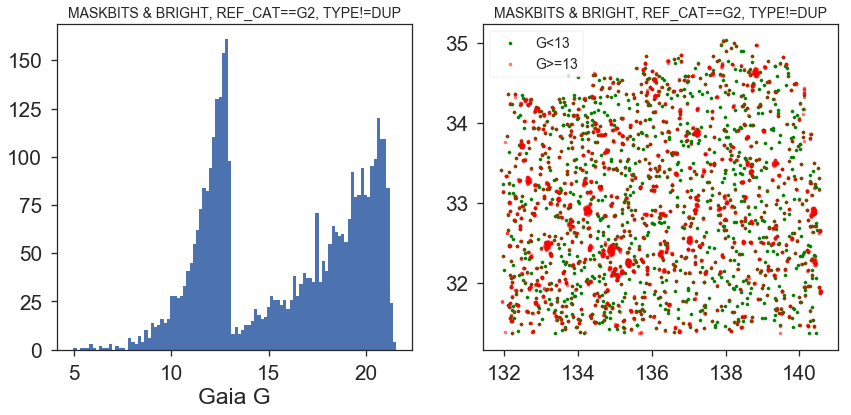

In [126]:
ibright = np.where(((gaia['MASKBITS'] & MASKBITS['BRIGHT']) != 0) * (gaia['REF_CAT'] == 'G2') * (gaia['TYPE'] != 'DUP'))[0]
#bb = (gaia['BRIGHTBLOB'][ibright] & IN_BLOB['BRIGHT'] != 0) == False
#gaia[ibright][bb]
#gaia[ibright]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
_ = ax1.hist(gaia[ibright]['GAIA_PHOT_G_MEAN_MAG'], bins=100)
ax1.set_xlabel('Gaia G')
ax1.set_title('MASKBITS & BRIGHT, REF_CAT==G2, TYPE!=DUP', fontsize=14)

isb = np.where(gaia[ibright]['GAIA_PHOT_G_MEAN_MAG'] < 13.0)[0]
isf = np.where(gaia[ibright]['GAIA_PHOT_G_MEAN_MAG'] >= 13.0)[0]
print(len(isb), len(isf))

ax2.scatter(gaia['RA'][ibright][isb], gaia['DEC'][ibright][isb], s=10, color='green', label='G<13')
ax2.scatter(gaia['RA'][ibright][isf], gaia['DEC'][ibright][isf], s=10, color='red', alpha=0.5, label='G>=13')
ax2.legend(fontsize=14, frameon=True)
ax2.set_title('MASKBITS & BRIGHT, REF_CAT==G2, TYPE!=DUP', fontsize=14)

#ax.set_xlim(136.8, 137.2)
#ax.set_ylim(32.4, 32.8)

print(np.sum(gaia['BRIGHTBLOB'][ibright][isf] & IN_BLOB['BRIGHT'] != 0))
check = np.where(gaia['BRIGHTBLOB'][ibright][isf] & IN_BLOB['BRIGHT'] == 0)[0] # no bright targeting bit set

for key in MASKBITS.keys():
    print(key, np.sum(gaia['MASKBITS'][ibright][isf][check] & MASKBITS[key] != 0))

gaia[ibright][isf][check]

#### Make sure the MASKBITS values are set correctly.

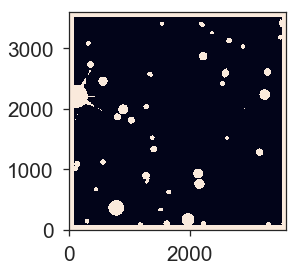

In [156]:
mask = fitsio.read('decam/coadd/132/1325p325/legacysurvey-1325p325-maskbits.fits.fz')
#print(mask.max())
c = plt.imshow(mask > 0, origin='lower')
#plt.colorbar(c)

In [152]:
ww = gaia['BRICKNAME'] == '1325p325'
eq = []
for obj in gaia[ww]:
    eq.append(mask[int(obj['BY']), int(obj['BX'])] == obj['MASKBITS'])
assert(np.all(eq))

In [ ]:
stop

In [15]:
import seaborn as sns
sns.set(context='talk', style='ticks', font_scale=1.6)
%matplotlib inline

In [134]:
cat = Table.read('check-lslga-90prime-mosaic.fits')
#cat = Table.read('check-lslga-decam.fits')
#cat['RA_LSLGA', 'DEC_LSLGA', 'RA', 'DEC']
cat

LSLGA_ID,GALAXY,PGC,RA_LSLGA,DEC_LSLGA,MORPHTYPE,BAR,RING,MULTIPLE,COMPACTNESS,T,PA,D25,BA,DIAM_REF,Z,SB_D25,MAG,MAG_REF,WISE_RA,WISE_DEC,CNTR,W1MPRO,W1SIGMPRO,W2MPRO,W2SIGMPRO,W3MPRO,W3SIGMPRO,W4MPRO,W4SIGMPRO,RCHI2,CC_FLAGS,EXT_FLG,PH_QUAL,XSCPROX,W1RSEMI,W1BA,W1PA,W1GMAG,W1GERR,W2GMAG,W2GERR,W3GMAG,W3GERR,W4GMAG,W4GERR,IN_ALLWISE,IN_DESI,NEAR_BRIGHTSTAR,TYPE,RA,DEC,REF_CAT,REF_ID,FRACDEV,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2
int64,bytes29,int64,float64,float64,bytes4,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,bytes3,float32,float32,float32,bytes1,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,bytes4,int32,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bytes4,float64,float64,bytes2,int64,float32,float32,float32,float32,float32,float32,float32
464247,SDSSJ085935.87+332955.7,3527266,134.89949099999998,33.4987998,nan,nan,nan,nan,nan,nan,114.31,0.33806482,0.5533501,iso,0.06275041,24.539482,18.266,B,134.8996367,33.4987789,1349133301351038765,15.583,0.043,15.136,0.095,11.865,nan,8.713,0.417,1.0,0000,0,AAUC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False,COMP,134.89951084746366,33.49878528294332,L2,464247,0.6740679,2.6010725,0.050863888,-0.5552968,36.004456,-0.5762295,-0.13428047
1115550,PGC2033387,2033387,135.01467150000002,33.5036415,Sc,nan,nan,nan,nan,4.8,98.65,0.60394865,0.33265957,iso,0.05400636,24.668482,17.135,B,135.0137599,33.5035077,1349133301351038644,14.738,0.04,14.49,0.066,10.625,0.195,8.176,0.469,1.315,0000,0,AABC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False,COMP,135.01464398408993,33.5036500276064,L2,1115550,0.2922864,14.088397,-0.52792394,-0.18845485,9.788278,-0.56356716,0.41398
1306643,PGC2032026,2032026,135.1348755,33.4365968,Sc,nan,nan,nan,nan,4.7,13.82,0.4775293,0.38370723,iso,0.03228433,23.637482,16.614,B,135.134613,33.4358122,1349133301351027172,13.13,0.029,12.881,0.033,8.856,0.046,7.249,0.224,2.038,0000,5,AAAB,2.77,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False,DEV,135.13495151084587,33.43666806718594,L2,1306643,1.0,0.0,0.0,0.0,20.181498,0.5638052,0.33804032
752523,PGC2024715,2024715,135.737262,33.147247,Sc,nan,nan,nan,nan,4.8,99.64,0.5164164,0.2660725,iso,0.05394165,24.924482,17.731,B,135.7367022,33.1473699,1349133301351020204,13.648,0.029,13.42,0.035,10.019,0.072,8.113,0.318,1.65,0000,4,AAAB,3.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False,EXP,135.7373825332178,33.14721617564274,L2,752523,0.0,8.310581,-0.687338,-0.23611833,0.0,0.0,0.0
844474,SDSSJ090256.11+331947.9,3997320,135.733869,33.3300327,nan,nan,nan,nan,nan,nan,162.87,0.4246196,0.25351286,iso,0.05298232,25.48648,18.718,B,135.7338482,33.3300261,1349133301351022633,14.65,0.031,14.513,0.053,11.429,0.212,8.378,nan,1.31,0000,0,AABU,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False,EXP,135.7338241159801,33.33000930916235,L2,844474,0.0,4.8737965,0.6821942,-0.35764194,0.0,0.0,0.0
39736,PGC2020347,2020347,135.09497850000002,33.005798399999996,E,nan,nan,nan,nan,-5.0,45.73,0.3349654,0.58884364,iso,0.08508386,23.72048,17.467,B,135.0950131,33.0057851,1349133301351015850,13.412,0.025,13.34,0.036,12.128,nan,7.876,nan,1.793,0000,0,AAUU,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,True,True,False,DEV,135.09500081346897,33.00575772148336,L2,39736,1.0,0.0,0.0,0.0,1.8303574,0.011112841,0.11775599
574722,PGC2021714,2021714,135.093909,33.0483935,Sc,nan,nan,nan,nan,4.7,44.63,0.4988845,0.30760968,iso,0.08631605,24.50148,17.383,B,135.093444,33.0479634,1349133301351015844,13.654,0.032,13.516,0.043,10.566,0.139,7.713,nan,1.788,0000,4,AABU,1.11,12.85,0.52,45.0,13.116,0.008,13.07,0.022,10.701,0.095,9.115,0.773,True,True,False,DEV,135.09413452179237,33.048564018856005,L2,574722,1.0,0.0,0.0,0.0,12.90153,0.019404238,0.64767253
120225,PGC2050068,2050068,135.52961100000002,34.4937343,Sc,nan,nan,nan,nan,6.1,71.56,0.55462575,0.3280953,iso,0.03

0.02315007664606128 2.4967798067331124 0.007758964645177002 0.9894684045733837


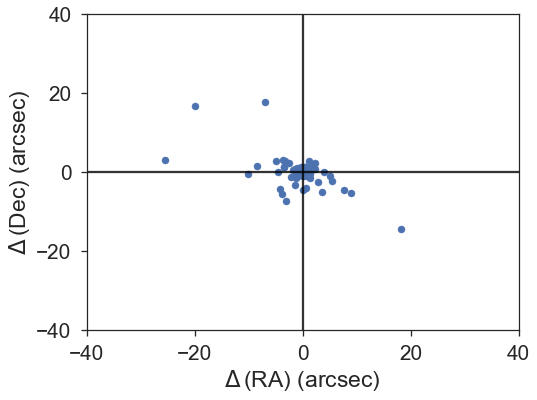

In [135]:
dra, ddec = (cat['RA'] - cat['RA_LSLGA']).data * 3600, (cat['DEC'] - cat['DEC_LSLGA']).data * 3600
print(np.median(dra), np.std(dra), np.median(ddec), np.std(ddec))
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(dra, ddec, s=50)
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.axhline(y=0, ls='-', alpha=0.8, color='k')
ax.axvline(x=0, ls='-', alpha=0.8, color='k')
ax.set_xlabel(r'$\Delta\,$(RA) (arcsec)')
ax.set_ylabel(r'$\Delta\,$(Dec) (arcsec)')
plt.subplots_adjust(bottom=0.15, left=0.15)
fig.savefig('lslga-radec.png')

In [136]:
def get_e1e2(ba, phi):
    ab = 1. / ba
    e = (ab - 1) / (ab + 1)
    ee = -np.log(1 - e)
    angle = np.deg2rad(2. * (-phi))
    ee1 = ee * np.cos(angle)
    ee2 = ee * np.sin(angle)
    return ee1, ee2
        
def type2properties(cat, objtype):
    this = np.where([objtype == tt.strip() for tt in cat['TYPE']])[0]
    if objtype == 'EXP' or objtype == 'REX':
        reff, e1, e2 = cat['SHAPEEXP_R'][this], cat['SHAPEEXP_E1'][this], cat['SHAPEEXP_E2'][this]
    elif objtype == 'DEV':
        reff, e1, e2 = cat['SHAPEDEV_R'][this], cat['SHAPEDEV_E1'][this], cat['SHAPEDEV_E2'][this]
        
    lslga_rad = cat['D25'][this] / 2 * 60 / 2 # [arcmin]
    lslga_e1, lslga_e2 = get_e1e2(cat['BA'][this], 180-cat['PA'][this])
        
    return reff, e1, e2, lslga_rad, lslga_e1, lslga_e2, cat[this]

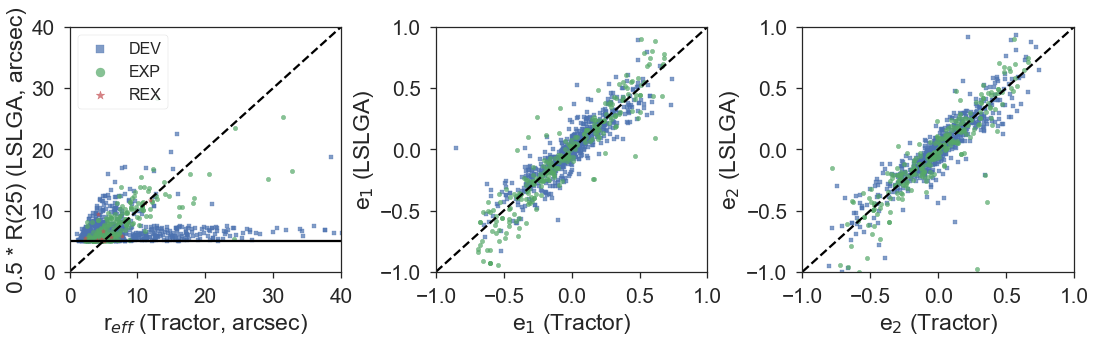

In [137]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
#for objtype in ('COMP', 'DEV', 'EXP', 'PSF', 'REX'):
for objtype, marker in zip(('DEV', 'EXP', 'REX'), ('s', 'o', '*')):
    reff, e1, e2, lslga_rad, lslga_e1, lslga_e2, _ = type2properties(cat, objtype)
    ax[0].scatter(reff, lslga_rad, label=objtype, s=20, alpha=0.7, marker=marker)
    if objtype != 'REX':
        ax[1].scatter(e1, lslga_e1, s=20, alpha=0.7, marker=marker)
        ax[2].scatter(e2, lslga_e2, s=20, alpha=0.7, marker=marker)
ax[0].set_xlim(0, 40)
ax[0].set_ylim(0, 40)
ax[0].axhline(y=5, color='k')
ax[0].set_xlabel(r'r$_{eff}$ (Tractor, arcsec)')
ax[0].set_ylabel(r'0.5 * R(25) (LSLGA, arcsec)')
ax[1].set_xlabel(r'e$_1$ (Tractor)')
ax[1].set_ylabel(r'e$_1$ (LSLGA)')
ax[2].set_xlabel(r'e$_2$ (Tractor)')
ax[2].set_ylabel(r'e$_2$ (LSLGA)')
for xx in ax[1:]:
    xx.set_xlim(-1, 1)
    xx.set_ylim(-1, 1)
leg = ax[0].legend(loc='upper left', frameon=True, fontsize=16, markerscale=2)
for l in leg.get_lines():
    l.set_alpha(1)
for xx in ax:
    xx.plot(xx.get_xlim(), xx.get_ylim(), color='k', ls='--')
plt.subplots_adjust(wspace=0.35, bottom=0.2)
plt.savefig('check-lslga.png')

In [10]:
reff, e1, e2, lslga_rad, lslga_e1, lslga_e2, devcat = type2properties(cat, 'DEV')
big = np.where(reff > 25)[0]
for cc in devcat[big][:20]:
    size = np.round(cc['D25'] * 1.5 * 60 / 0.262).astype(int)
    montagefile = 'montage/{}.jpg'.format(cc['GALAXY'].lower())
    jpgfile = []
    #print('http://legacysurvey.org/viewer-dev?ra={}&dec={}&zoom=14&layer=dr8b-decam&lslga'.format(cc['RA'], cc['DEC']))
    for ii, imtype in enumerate(('', '-model', '-resid')):
        jpgfile.append('jpg/{}{}.jpg'.format(cc['GALAXY'].lower(), imtype))
        url = '"http://legacysurvey.org/viewer-dev/jpeg-cutout?ra={}&dec={}&size={}&layer=dr8c-90p-mos{}"'.format(
            cc['RA'], cc['DEC'], size, imtype)
        if not os.path.exists(jpgfile[ii]):
            cmd = 'wget --continue -O {} {}'.format(jpgfile[ii], url)
            print(cmd)
            os.system(cmd)
            time.sleep(1)
    cmd = 'montage -bordercolor white -borderwidth 1 -tile 3x1 -geometry +0+0 '
    cmd = cmd+' '.join(ff for ff in jpgfile)
    cmd = cmd+' {}'.format(montagefile)
    print(cmd)
    os.system(cmd)    

montage -bordercolor white -borderwidth 1 -tile 3x1 -geometry +0+0 jpg/sdssj090410.13+324600.7.jpg jpg/sdssj090410.13+324600.7-model.jpg jpg/sdssj090410.13+324600.7-resid.jpg montage/sdssj090410.13+324600.7.jpg
montage -bordercolor white -borderwidth 1 -tile 3x1 -geometry +0+0 jpg/sdssj084954.64+323912.1.jpg jpg/sdssj084954.64+323912.1-model.jpg jpg/sdssj084954.64+323912.1-resid.jpg montage/sdssj084954.64+323912.1.jpg
montage -bordercolor white -borderwidth 1 -tile 3x1 -geometry +0+0 jpg/ngc2683.jpg jpg/ngc2683-model.jpg jpg/ngc2683-resid.jpg montage/ngc2683.jpg
montage -bordercolor white -borderwidth 1 -tile 3x1 -geometry +0+0 jpg/sdssj085837.36+312856.6.jpg jpg/sdssj085837.36+312856.6-model.jpg jpg/sdssj085837.36+312856.6-resid.jpg montage/sdssj085837.36+312856.6.jpg
montage -bordercolor white -borderwidth 1 -tile 3x1 -geometry +0+0 jpg/sdssj085906.18+331043.2.jpg jpg/sdssj085906.18+331043.2-model.jpg jpg/sdssj085906.18+331043.2-resid.jpg montage/sdssj085906.18+331043.2.jpg
montage -